In [1]:
import pickle
import numpy as np
from tqdm.notebook import trange, tqdm
import json
from sklearn.metrics import roc_curve, auc
from features import get_transformer, merge_entries
import sys
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class AV_Model(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.fc_1 = nn.Sequential(
            nn.Linear(input_sz, hidden_sz),
            nn.Dropout(p=0.5)
        )
        self.bn = nn.BatchNorm1d(hidden_sz)
        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_sz, 1),
            nn.Dropout(p=0.5)
        )
    
    def forward_once(self, x):
        x = F.relu(self.fc_1(x))
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)
        x = self.bn(torch.abs(x1 - x2))
        
        x = torch.sigmoid(self.fc_2(x))
        
        return x

In [5]:
class PANDataset(torch.utils.data.Dataset):
    def __init__(self, x_1_path, x_2_path, y_path, vector_sz, feature_sz):
        self.XX_1 = np.memmap(x_1_path, dtype='float32', mode='r', shape=(vector_sz, feature_sz))
        self.XX_2 = np.memmap(x_2_path, dtype='float32', mode='r', shape=(vector_sz, feature_sz))
        
        self.Y = np.memmap(y_path, dtype='int32', mode='r', shape=(vector_sz))


    def __getitem__(self, index):
        x_1 = np.array(self.XX_1[index, :])
        x_2 = np.array(self.XX_2[index, :])
        return x_1, x_2, np.array(self.Y[index]).astype('float32')

    def __len__(self):
        return len(self.Y)

In [6]:
DATA_DIR = 'data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
PREPROCESSED_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/'
# TEMP_DATA_PATH = 'temp_data/pan/'
TEMP_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/'

In [6]:
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']

In [7]:
with open(TEMP_DATA_PATH + 'model.p', 'rb') as f:
    (clf, transformer, scaler, secondary_scaler) = pickle.load(f)

/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator FeatureUnion from version 0.22.1 when using version 0.24.1. This might lead to breaking code

In [7]:
with open(TEMP_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (
        aucs,
        clf,
        roc_auc,
        transformer, 
        scaler,
        secondary_scaler,
        feature_sz,
        train_sz,
        train_idxs,
        test_sz,
        test_idxs
    ) = pickle.load(f)

/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator FeatureUnion from version 0.22.1 when using version 0.24.1. This might lead to breaking code

In [9]:
def vectorize(x_path_1, x_path_2, y_path, ordered_idxs, transformer, scaler, preprocessed_path, vector_sz, feature_sz):
    XX_1 = np.memmap(x_path_1, dtype='float32', mode='w+', shape=(vector_sz, feature_sz))
    XX_2 = np.memmap(x_path_2, dtype='float32', mode='w+', shape=(vector_sz, feature_sz))
    Y = np.memmap(y_path, dtype='int32', mode='w+', shape=(vector_sz))
    with open(preprocessed_path, 'r') as f:
        batch_size = 1000
        i = 0;
        docs1 = []
        docs2 = []
        idxs = []
        labels = []
        for l in tqdm(f, total=vector_sz):
            d = json.loads(l)
            
            docs1.append(merge_entries(d['pair'][0]))
            docs2.append(merge_entries(d['pair'][1]))

            labels.append(ground_truth[d['id']])
            idxs.append(ordered_idxs[i])
            i += 1
            if i % 100 == 0:
                sys.stdout.flush()
            if len(labels) >= batch_size:
                x1 = scaler.transform(transformer.transform(docs1).todense())
                x2 = scaler.transform(transformer.transform(docs2).todense())
                XX_1[idxs, :] = x1
                XX_2[idxs, :] = x2
                Y[idxs] = labels

                docs1 = []
                docs2 = []
                idxs = []
                labels = []
                print(i)

        x1 = scaler.transform(transformer.transform(docs1).todense())
        x2 = scaler.transform(transformer.transform(docs2).todense())
        XX_1[idxs, :] = x1
        XX_2[idxs, :] = x2
        Y[idxs] = labels
        XX_1.flush()
        XX_2.flush()
        Y.flush()
        
        return XX_1, XX_2, Y

In [ ]:
XX_1_train, XX_2_train, Y_train = vectorize(
    TEMP_DATA_PATH + 'vectorized_XX_1_train.npy',
    TEMP_DATA_PATH + 'vectorized_XX_2_train.npy',
    TEMP_DATA_PATH + 'Y_train.npy',
    train_idxs, 
    transformer, 
    scaler, 
    PREPROCESSED_DATA_PATH + 'preprocessed_train.jsonl',
    train_sz,
    feature_sz
)

In [ ]:
XX_1_test, XX_2_test, Y_test = vectorize(
    TEMP_DATA_PATH + 'vectorized_XX_1_test.npy',
    TEMP_DATA_PATH + 'vectorized_XX_2_test.npy',
    TEMP_DATA_PATH + 'Y_test.npy',
    test_idxs, 
    transformer, 
    scaler, 
    PREPROCESSED_DATA_PATH + 'preprocessed_test.jsonl',
    test_sz,
    feature_sz
)

In [8]:
model = AV_Model(feature_sz, 300)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
train = PANDataset(TEMP_DATA_PATH + 'vectorized_XX_1_train.npy', TEMP_DATA_PATH + 'vectorized_XX_2_train.npy', TEMP_DATA_PATH + 'Y_train.npy', train_sz, feature_sz)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)

test = PANDataset(TEMP_DATA_PATH + 'vectorized_XX_1_test.npy', TEMP_DATA_PATH + 'vectorized_XX_2_test.npy', TEMP_DATA_PATH + 'Y_test.npy', test_sz, feature_sz)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
#initialize empty list to track batch losses
train_losses = []
validation_losses = []
model.to(device)
#train the neural network for 5 epochs
for epoch in range(40):
    model.train()
    train_loss = 0.0
    for x1, x2, y in tqdm(train_loader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        optimizer.zero_grad()
        
        out = model(x1, x2)
        loss = criterion(out, y)
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    
    preds = []
    labels = []
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        out = model(x1, x2)
        loss = criterion(out, y)
        valid_loss += loss.item()
        
        out = out.reshape(-1).tolist()
        y = y.reshape(-1).tolist()
        preds.extend(out)
        labels.extend(y)
    fpr, tpr, thresh = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    train_losses.append(train_loss / len(train_loader))
    validation_losses.append(valid_loss / len(test_loader))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(test_loader)} \t\t AUC: {roc_auc}')
    torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')

/home/jnw301/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:104: UserWarning: 
NVIDIA A100-SXM4-80GB with CUDA capability sm_80 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA A100-SXM4-80GB GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


  0%|          | 0/1512 [00:00<?, ?it/s]

RuntimeError: CUDA error: no kernel image is available for execution on the device

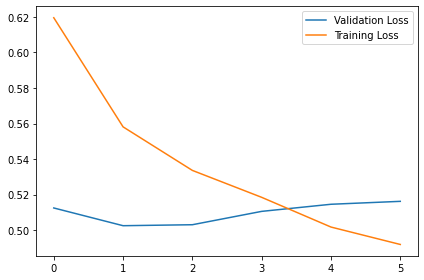

In [14]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.0001

In [ ]:
model.eval()
preds = []
labels = []
for x1, x2, y in test_loader:
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    out = model(x1, x2).reshape(-1).tolist()
    y = y.reshape(-1).tolist()
    preds.extend(out)
    labels.extend(y)

In [26]:
fpr, tpr, thresh = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9980857460054038


In [33]:
torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')